In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import copy

In [2]:
edges1 = {}

for i in range(10000):
    cluster_i = i // 100
    N_in = np.random.binomial(100, 0.4)
#     N_in = np.random.binomial(100, 0.5)
    in_poi = list(cluster_i * 100 + np.random.choice(100, N_in))
    N_out = np.random.binomial(10000, 0.0005)
    out_poi = list(np.random.choice(10000, N_out))
    for j in in_poi + out_poi:
        if j not in edges1:
            edges1[j] = {}
        edges1[j][i] = (np.random.poisson(1) + 1) 
        

In [3]:
redges1 = {}

for j in edges1:
    for i in edges1[j]:
        if i not in redges1:
            redges1[i] = {}
        redges1[i][j] = edges1[j][i]

In [4]:
edges2 = {}

degree = (np.random.power(0.25, 10000) * 100).astype(int) + 1

for i in range(10000):
    pois = list(np.random.choice(10000, degree[i]))
    for j in pois:
        if j not in edges2:
            edges2[j] = {}
        edges2[j][i] = np.random.poisson(1) + 1

In [5]:
redges2 = {}

for j in edges2:
    for i in edges2[j]:
        if i not in redges2:
            redges2[i] = {}
        redges2[i][j] = edges2[j][i]

In [7]:
for lamb in [0, 0.25, 0.5, 0.75, 1.0]:

    redges = {}

    for i in range(10000):
        redges[i] = {}
        for j in redges1[i]:
            if np.random.random() < 1 - lamb:
                redges[i][j] = redges1[i][j]
        for j in redges2[i]:
            if np.random.random() < lamb:
                redges[i][j] = redges2[i][j]

    edges = {}

    for i in redges:
        for j in redges[i]:
            if j not in edges:
                edges[j] = {}
            edges[j][i] = redges[i][j]


    dict_param = np.load('../data/dict_param_all_12.npy', allow_pickle=True).item()
    del dict_param['cbgs_idxs']
    del dict_param['centrality_scores']
    del dict_param['unvax']

    from scipy.sparse import csr_matrix

    row = [j for j in edges for i in edges[j]]
    col = [i for j in edges for i in edges[j]]
    data = [edges[j][i] for j in edges for i in edges[j]]

    bipartite = csr_matrix((data, (row, col)), shape=(10000, 10000))

    poi2idx = {i: i for i in range(10000)}
    cbg2idx = {i: i for i in range(10000)}

    dict_param['poi_cbg_visits_list'] = [bipartite]
    dict_param['poi_time_counts'] = np.array([np.ones(len(poi2idx))]).T
    dict_param['poi_areas'] = np.ones(10000) 
    dict_param['poi_dwell_time_correction_factors'] = np.ones(10000) 
    dict_param['cbg_sizes'] = (np.ones(10000) * 10000).astype(int)
    dict_param['all_unique_cbgs'] = list(range(10000))
    dict_param['poi_cbg_proportions'] = [{1: 0.9}] * len(poi2idx)


    unvax_1 = np.array([int((i // 100) % 2 == 0) * 0.6 + 0.2 for i in range(10000)])
    unvax_2 = np.array([0.6 - degree[i]/100*0.5 for i in range(10000)]) # np.array([int((i // 100) % 2 == 0) * 0.6 + 0.2 for i in range(10000)])

    unvax = unvax_1 * (1 - lamb) + unvax_2 * lamb

    #### 

    bipartite_w = csr_matrix((data, (row, col)), shape=(10000, 10000))

    ori_sizes = dict_param['cbg_sizes'] 

    avg_original = np.average(1 - unvax, weights=ori_sizes)

    vax_original = 1 - unvax

    vax_shuffle = 1 - unvax
    np.random.shuffle(vax_shuffle)
    avg_shuffle = np.average(vax_shuffle, weights=ori_sizes)
    vax_shuffle = vax_shuffle - avg_shuffle + avg_original

    vax_reverse = 1 - (1 - unvax)
    avg_reverse = np.average(vax_reverse, weights=ori_sizes)
    vax_reverse = vax_reverse - avg_reverse + avg_original

    vax_exchange = 1 - unvax

    centrality_scores_array = (bipartite_w.T @ bipartite_w).sum(axis=1)
    centrality_scores = {ii: centrality_scores_array[ii] for ii in range(len(centrality_scores_array))}
    centrality_scores = list(reversed(sorted(centrality_scores.items(), key=lambda x: x[1])))

    ii = 0
    for ii in range(int(0.01 * len(centrality_scores)), len(centrality_scores)):
        cbg = centrality_scores[ii][0]
        if ii % 2 == 0 and ii + 1 < len(centrality_scores):
            cbg2 = centrality_scores[ii+1][0]
            tmp = vax_exchange[cbg]
            vax_exchange[cbg] = vax_exchange[cbg2]
            vax_exchange[cbg2] = tmp
        ii += 1

    avg_exchange = np.average(vax_exchange, weights=ori_sizes)
    vax_exchange = vax_exchange - avg_exchange + avg_original

    vax_uniform = np.array([avg_original] * len(ori_sizes))

    for vax in [vax_original, vax_shuffle, vax_reverse, vax_exchange, vax_uniform]:
        print(bipartite_w.T @ bipartite_w @ (1 - vax) @ (1 - vax))

    centrality = (bipartite_w.T @ bipartite_w).sum(axis=1)

    dict_param['unvax'] = copy.deepcopy(unvax)
    dict_param['centrality'] = centrality
    dict_param['centrality_scores'] = centrality

    dict_param['cbgs_idxs'] = {i for i in range(10000)}

    np.save('../data/dict_param_synthetic_%f.npy' % (lamb), dict_param)
    print(np.array(centrality))

18742209.520000003
14912606.8
18904267.119999997
14862875.799999999
14777257.0
[[5332]
 [5122]
 [5615]
 ...
 [6338]
 [6327]
 [5305]]
12558489.086510926
11642253.179267177
13180244.836764544
11334623.208292183
11559434.597841643
[[3976]
 [4054]
 [3929]
 ...
 [5565]
 [4102]
 [3308]]
8037738.898631251
8808914.351568753
10111463.135050517
7796800.169337498
8761403.171092343
[[2733]
 [3109]
 [2537]
 ...
 [5924]
 [2604]
 [2977]]
4554770.997939062
6411483.496539057
8571505.225290162
4539214.3677906245
6365443.647356179
[[1089]
 [2410]
 [1554]
 ...
 [5211]
 [1143]
 [1019]]
1883337.0820999998
4352498.796575008
7852190.5609268965
1883425.0088000002
4333486.212159359
[[ 371]
 [ 962]
 [ 179]
 ...
 [3612]
 [ 106]
 [ 183]]


In [8]:
! parallel --jobs 5 < run-synthetic.sh

Academic tradition requires you to cite works you base your article on.
When using programs that use GNU Parallel to process data for publication
please cite:

  O. Tange (2011): GNU Parallel - The Command-Line Power Tool,
  ;login: The USENIX Magazine, February 2011:42-47.

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

To silence this citation notice: run 'parallel --citation'.

False synthetic_1.000000
[0.42  0.455 0.41  ... 0.61  0.405 0.41 ]
[0.42  0.455 0.41  ... 0.61  0.405 0.41 ]
Adjusted POI transmission rates with dwell time correction factors
Received POI_CBG_VISITS_LIST, will NOT be computing hourly matrices on the fly
=== PARAMETERS ===
poi_psi = 0.1, home_beta = 0.0, p_sick_at_t0 = 0.0001, num_hours = 720
POI factors (psi * dwell_time_factor / area) for first 10 POIs
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
simulating confirmed cases: True, simulating deaths: True
=== RE

2287673.04 2480864.8 288437.60000000003 301804.92 131617.76
0.000000 1.084449025984937 0.12608340219806938 0.13192659734277412 0.2952
189827.72 248446.76 81088.95999999999 94574.72 31773.719999999998
0.250000 1.3088012646414338 0.42717133198460155 0.4982134326851737 0.23225425
29804.72 94832.36 25411.16 44435.16 10860.16
0.500000 3.1817899983626754 0.8525884490778641 1.4908766128317932 0.158915
6271.88 142196.32 6190.44 26709.84 3832.56
0.750000 22.67204091915024 0.9870150576860526 4.258665663246108 0.08162475
1296.72 391710.2 1294.2 34341.64 1301.2
1.000000 302.0777037448331 0.9980566352026652 26.483465975692514 0.010643000000000001


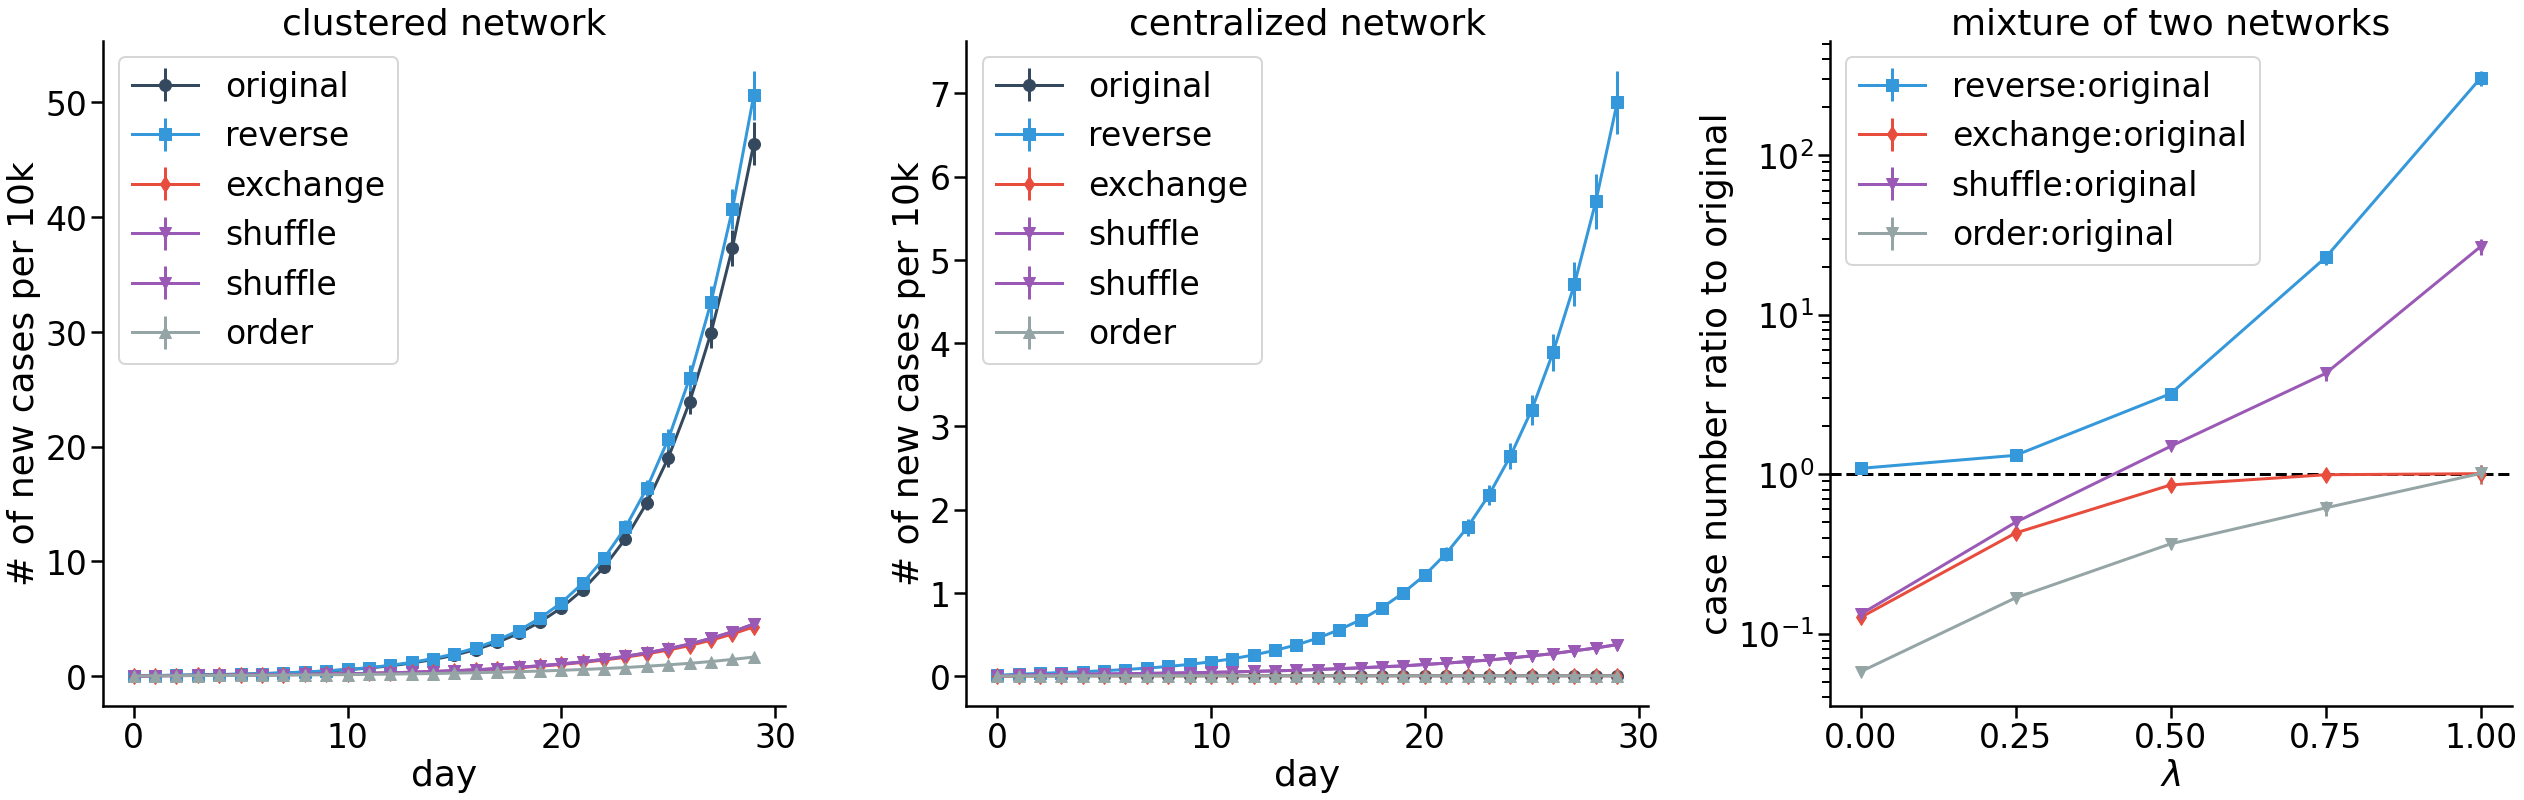

In [11]:
import pandas as pd
num_days = 720

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('poster', font_scale=1.5)

plt.figure(figsize=(36, 12))

synthetic_results = {}

ii = 0
plt_loc = 130

plot_data = []

for name in ['0.000000', '0.250000', '0.500000', '0.750000', '1.000000']:
    
    
    results = np.load('../results/results_synthetic_%s_0.npy' % (name), allow_pickle=True).item()
    
    for key in results:
        synthetic_results[float(name)] = (results[key]['original'].history['all']['new_cases'][:, :num_days].mean(axis=0).sum(),
              results[key]['reverse'].history['all']['new_cases'][:, :num_days].mean(axis=0).sum(),
              results[key]['exchange_ori'].history['all']['new_cases'][:, :num_days].mean(axis=0).sum(),
              results[key]['shuffle'].history['all']['new_cases'][:, :num_days].mean(axis=0).sum(),
              results[key]['order'].history['all']['new_cases'][:, :num_days].mean(axis=0).sum())
        
        print(results[key]['original'].history['all']['new_cases'][:, :num_days].mean(axis=0).sum(),
              results[key]['reverse'].history['all']['new_cases'][:, :num_days].mean(axis=0).sum(),
              results[key]['exchange_ori'].history['all']['new_cases'][:, :num_days].mean(axis=0).sum(),
              results[key]['shuffle'].history['all']['new_cases'][:, :num_days].mean(axis=0).sum(),
              results[key]['order'].history['all']['new_cases'][:, :num_days].mean(axis=0).sum()
             )

    print(name, 
          synthetic_results[float(name)][1] / synthetic_results[float(name)][0],
          synthetic_results[float(name)][2] / synthetic_results[float(name)][0],
          synthetic_results[float(name)][3] / synthetic_results[float(name)][0],
          np.mean(np.abs(results[key]['cache']['original'] - results[key]['cache']['exchange_ori']))
         )
    
    if float(name) == 0 or float(name) == 1:
        plt_loc += 1
        plt.subplot(plt_loc)
        for arg in [
            {'key1': 'original', 'key2': 'original', 'color': '#34495e', 'marker': 'o', 'seq': 1},
            {'key1': 'reverse', 'key2': 'reverse', 'color': '#3498db', 'marker': 's', 'seq': 2},
            {'key1': 'exchange_ori', 'key2': 'exchange', 'color': '#e74c3c', 'marker': 'd', 'seq': 3},
            {'key1': 'shuffle', 'key2': 'shuffle', 'color': '#9b59b6', 'marker': 'v', 'seq': 4},
            {'key1': 'shuffle', 'key2': 'shuffle', 'color': '#9b59b6', 'marker': 'v', 'seq': 5}
        ]:

            plt.errorbar(
                    x=range(num_days//24),
                    y=[results[key][arg['key1']].history['all']['new_cases'][:, k:k+24].mean(axis=0).sum(axis=0)*10000/results[key]['original'].CBG_SIZES.sum() for k in range(0, 720, 24)],
                    yerr=[results[key][arg['key1']].history['all']['new_cases'][:, k:k+24].sum(axis=1).std(ddof=1, axis=0)*10000/results[key]['original'].CBG_SIZES.sum() for k in range(0, 720, 24)], 
                    color=arg['color'],
                    marker=arg['marker'],
                    label=arg['key2']
                )
            
        if float(name) == 1:
            plt.title('centralized network')
        if float(name) == 0:
            plt.title('clustered network')
        plt.xlabel('day')
        plt.ylabel('# of new cases per 10k')
            
        plt.errorbar(
            x=range(num_days//24),
            y=[results[key]['order'].history['all']['new_cases'][:, k:k+24].mean(axis=0).sum(axis=0)*10000/results[key]['original'].CBG_SIZES.sum() for k in range(0, 720, 24)],
            yerr=[results[key]['order'].history['all']['new_cases'][:, k:k+24].sum(axis=1).std(ddof=1, axis=0)*10000/results[key]['original'].CBG_SIZES.sum() for k in range(0, 720, 24)], 
            color='#95a5a6',
            marker='^',
            label='order')
        
        plt.legend()
    
    r = results[key]['reverse'].history['all']['new_cases'][:, :].sum(axis=1) / results[key]['original'].history['all']['new_cases'][:, :].sum(axis=1)
    e = results[key]['exchange_ori'].history['all']['new_cases'][:, :].sum(axis=1) / results[key]['original'].history['all']['new_cases'][:, :].sum(axis=1)
    s = results[key]['shuffle'].history['all']['new_cases'][:, :].sum(axis=1) / results[key]['original'].history['all']['new_cases'][:, :].sum(axis=1)
    o = results[key]['order'].history['all']['new_cases'][:, :].sum(axis=1) / results[key]['original'].history['all']['new_cases'][:, :].sum(axis=1)
    
    for i in range(25):
        plot_data.append({
            'lambda': float(name),
            'tag': 'reverse:original',
            'value': r[i]
        })
        plot_data.append({
            'lambda': float(name),
            'tag': 'exchange:original',
            'value': e[i]
        })
        plot_data.append({
            'lambda': float(name),
            'tag': 'shuffle:original',
            'value': s[i]
        })
        plot_data.append({
            'lambda': float(name),
            'tag': 'order:original',
            'value': o[i]
        })
        
plt.subplot(133)
plot_data = pd.DataFrame.from_dict(plot_data)

# sns.set_context('poster', font_scale=1.2)
tmp = plot_data[plot_data['tag'] == 'reverse:original']

plt.errorbar(x = [0, 0.25, 0.5, 0.75, 1.0],
             y = tmp.groupby('lambda')['value'].mean(),
             yerr = tmp.groupby('lambda')['value'].std(),
             color = '#3498db',
             marker = 's', 
             label= 'reverse:original'
            )

tmp = plot_data[plot_data['tag'] == 'exchange:original']

plt.errorbar(x = [0, 0.25, 0.5, 0.75, 1.0],
             y = tmp.groupby('lambda')['value'].mean(),
             yerr = tmp.groupby('lambda')['value'].std(),
             color = '#e74c3c',
             marker = 'd', 
             label= 'exchange:original'
            )

tmp = plot_data[plot_data['tag'] == 'shuffle:original']

plt.errorbar(x = [0, 0.25, 0.5, 0.75, 1.0],
             y = tmp.groupby('lambda')['value'].mean(),
             yerr = tmp.groupby('lambda')['value'].std(),
             color = '#9b59b6',
             marker = 'v', 
             label= 'shuffle:original'
            )

tmp = plot_data[plot_data['tag'] == 'order:original']

plt.errorbar(x = [0, 0.25, 0.5, 0.75, 1.0],
             y = tmp.groupby('lambda')['value'].mean(),
             yerr = tmp.groupby('lambda')['value'].std(),
             color = '#95a5a6',
             marker = 'v', 
             label= 'order:original'
            )

plt.axhline(1.0, linestyle='--', color='k')

plt.title('mixture of two networks')
plt.yscale('log')
plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.ylabel('case number ratio to original')
plt.xlabel(r'$\lambda$')
sns.despine()
plt.legend()
plt.tight_layout()